# Sentence data exploration

Now that we have the text data split into sentences, let's load them up and take a quick look at what we have.

## Notebook setup

In [1]:
# Change working directory to parent so we can import as we would
# from the perplexity ratio score root directory
%cd ..

# PyPI imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Internal imports
import configuration as config

/mnt/arkk/llm_detector/perplexity_ratio_score


## 1. Data loading

In [2]:
data_file=f'{config.INTERMEDIATE_DATA_PATH}/all_sentences.json'
data_df=pd.read_json(data_file)
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66421891 entries, 0 to 66421890
Data columns (total 4 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   text       object
 1   synthetic  int64 
 2   author     object
 3   source     object
dtypes: int64(1), object(3)
memory usage: 2.0+ GB


In [3]:
data_df.head()

,text,synthetic,author,source
0,The most significant misunderstanding occurred...,0,human,grinberg
1,"Lawrence: University Press of Kansas, 1994.",0,human,grinberg
2,"Contrast that with Cal junior Jared Goff, a pr...",0,human,yatsenko
3,"In this Chapter, we'll merely try to define a ...",0,human,yatsenko
4,Our planet needs its inhibitors to treat it wi...,0,human,gerami


## 2. Data composition

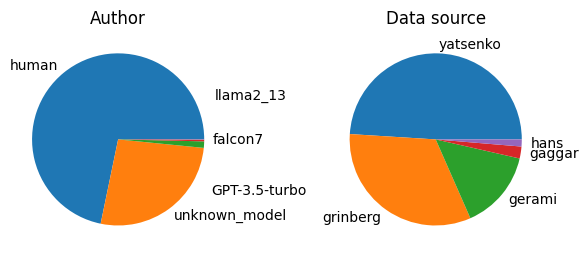

In [4]:
def fix_labels(mylabels, tooclose=0.1, sepfactor=2):
    vecs=np.zeros((len(mylabels), len(mylabels), 2))
    dists=np.zeros((len(mylabels), len(mylabels)))

    for i in range(0, len(mylabels)-1):
        for j in range(i+1, len(mylabels)):
            a=np.array(mylabels[i].get_position())
            b=np.array(mylabels[j].get_position())
            dists[i,j]=np.linalg.norm(a-b)
            vecs[i,j,:]=a-b
            
            if dists[i,j] < tooclose:
                mylabels[i].set_x(a[0] + sepfactor*vecs[i,j,0])
                mylabels[i].set_y(a[1] + sepfactor*vecs[i,j,1])
                mylabels[j].set_x(b[0] - sepfactor*vecs[i,j,0])
                mylabels[j].set_y(b[1] - sepfactor*vecs[i,j,1])

authors=data_df['author'].value_counts()
datasets=data_df['source'].value_counts()

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(6, 3))
axs[0].set_title('Author')
wedges, labels=axs[0].pie(authors, labels=authors.index)
fix_labels(labels, sepfactor=10)
axs[1].set_title('Data source')
axs[1].pie(datasets, labels=datasets.index)
plt.tight_layout()
plt.show()

## 3. Text length

In [5]:
data_df['words']=data_df['text'].apply(lambda x: len(x.split(' ')))
data_df['words'].describe()

count    6.642189e+07
mean     1.836516e+01
std      4.467347e+01
min      1.000000e+00
25%      1.000000e+01
50%      1.600000e+01
75%      2.400000e+01
max      7.009800e+04
Name: words, dtype: float64

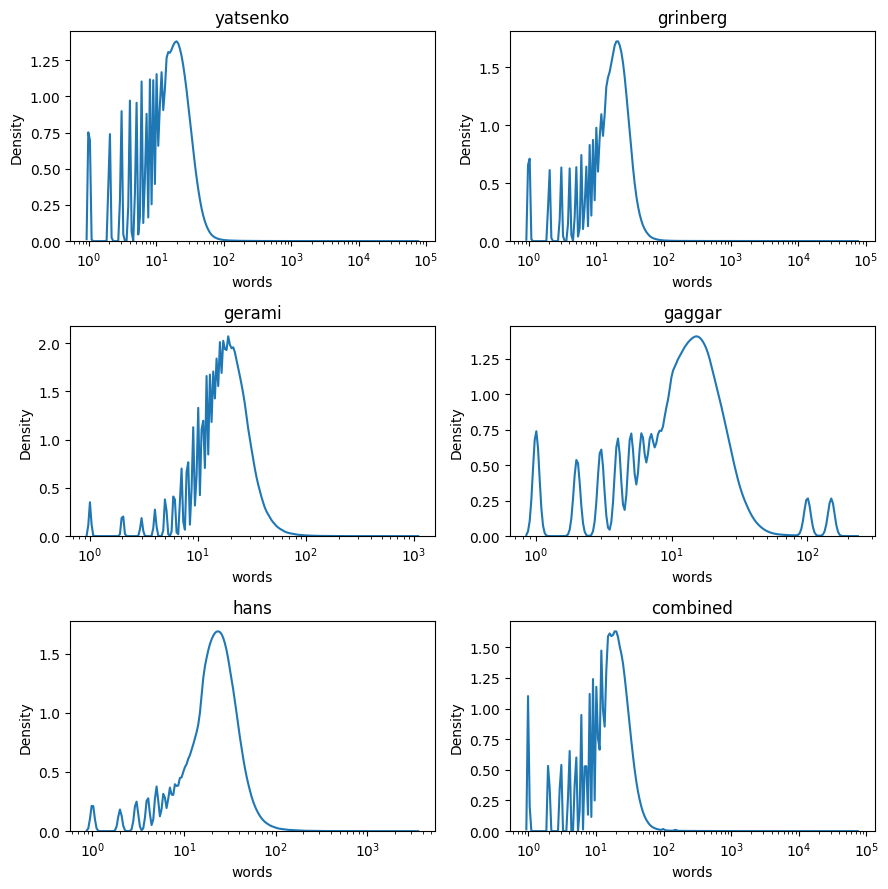

In [6]:
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(9, 9), squeeze=True)
axs=axs.flatten()

for i, dataset in enumerate(datasets.index):
    plot_data_df=data_df[data_df['source'] == dataset]
    sns.kdeplot(data=plot_data_df, x='words', log_scale=10, legend=False, ax=axs[i])
    axs[i].set_title(dataset)

sns.kdeplot(data=data_df, x='words', log_scale=10, legend=False, ax=axs[-1])
axs[-1].set_title('combined')
plt.tight_layout()
plt.show()

OK, coooool - love how you can see quantization at short sentence lengths. It reminds me of polysomes on a sucrose gradient! Peak for each data source is around 20 words, effective max is about 100 or so words with some very long sentences - out to tens of thousands of words? That has to be junk. We also have a pretty large peak of single word sentences. Let's take a look at some examples of both.

### 3.1. Very long sentences

In [8]:
very_long_records=data_df[data_df['words'] > 200]
very_long_records['words'].describe()

count    48901.000000
mean       783.980225
std       1386.509091
min        201.000000
25%        275.000000
50%        420.000000
75%        764.000000
max      70098.000000
Name: words, dtype: float64

About 1.5% of records are longer than 100 words, less than a tenth of a percent are longer than 200 words. Let's take a look a few.

In [9]:
print(very_long_records['text'].iloc[0][:500])

Initial Budget Process

Peyton Approved                    
Direct Labor Budget                
July, August, and September 2015   
                                     July      August    Sept.     Total     
Budgeted production (units)          67,200    61,600    56,000    184,800   
Labor requirements per unit (hours)  0.5       0.5       0.5                 
Total labor hours needed             33,600    30,800    28,000    92,400    
Labor rate (per hour)                16.00     16.00    


Ok, probably don't want this.

In [10]:
print(very_long_records['text'].iloc[1][:500])

Euglenophyte chloroplasts have three membranes - it is thought that the membrane of the thylakoid lumen, which contains photosystem II and associated proteins such as RuBisCO, was not present in this ancestor but developed later during eukaryotic evolution; see PhotosynthesisGreen algae eukaryotes bacteria mitochondria (nuclear) plants animals nuclei with cell wall plastids: Chromosomesnucleus Cell Wall-Plant Prokaryote Plant mitochondrion Human nucleus Stem cells Individual organelles Organelle


This one sounds like machine word salad.

In [11]:
print(very_long_records['text'].iloc[2][:500])

7.0%     10.8%   12.2%                                                    9.5%            
26 – 34                                                           Count    17      1                                                        0                 18                             
% within Which steakhouse restaurant are you most familiar with?


More tabular stuff. I think we could cut sentences off at 200 words without loosing much.

### 3.2. Very short sentences

In [12]:
very_short_records=data_df[data_df['words'] <= 5]
very_short_records['words'].describe()

count    8.592231e+06
mean     2.915418e+00
std      1.470170e+00
min      1.000000e+00
25%      2.000000e+00
50%      3.000000e+00
75%      4.000000e+00
max      5.000000e+00
Name: words, dtype: float64

Wow, lots of sentences shorter than 5 words. 8.6 million sentences is more than 10% of the data set. Let's see what a few look like.

In [13]:
print(very_short_records['text'].iloc[0])

I said.


OK - garbage. Try a few more:

In [14]:
for i in range(1,10):
    print(f"\n{very_short_records['text'].iloc[i]}")


*Devour.

He would

Good luck to

wise' he said'Sir.

4.

9, pp.

New York, NY: Cengage.

or ``Hey!!

We've been good.


Yep - also garbage.

In [15]:
for i in range(40,50):
    print(f"\n{very_short_records['text'].iloc[i]}")


But they're not the problem.

Print.

**DRIVER.

turn.

Morton, Carol Cruz an.

Roses?

But it didn't work.

" he asks.

32, no.

Now I'll ask again.


Yep, also garbage. Some of this is probably down to bad splits. The rest looks like just junk. I'm reluctant to set arbitrary length thresholds. Kinda feeling like maybe we should perplexity score the whole thing and think more about it after. That way we can more easily experiment with different length thresholds. If we trim now and then score, if we decide we want to change the thresholds later, we have to go back and re-score at least some of the data.

Just for fun, let's take a look at the sentence length distributions for human vs machine text. But before we do - let's provisionally get rid of any single word sentences - we can pretty clearly justify that as a splitting failure, if nothing else. And for plotting's sake, let's cut at 200 words too.

In [28]:
working_data_df=data_df[data_df['words'] > 1]
working_data_df=working_data_df[working_data_df['words'] < 100]

### 3.3. Text length: human vs machine

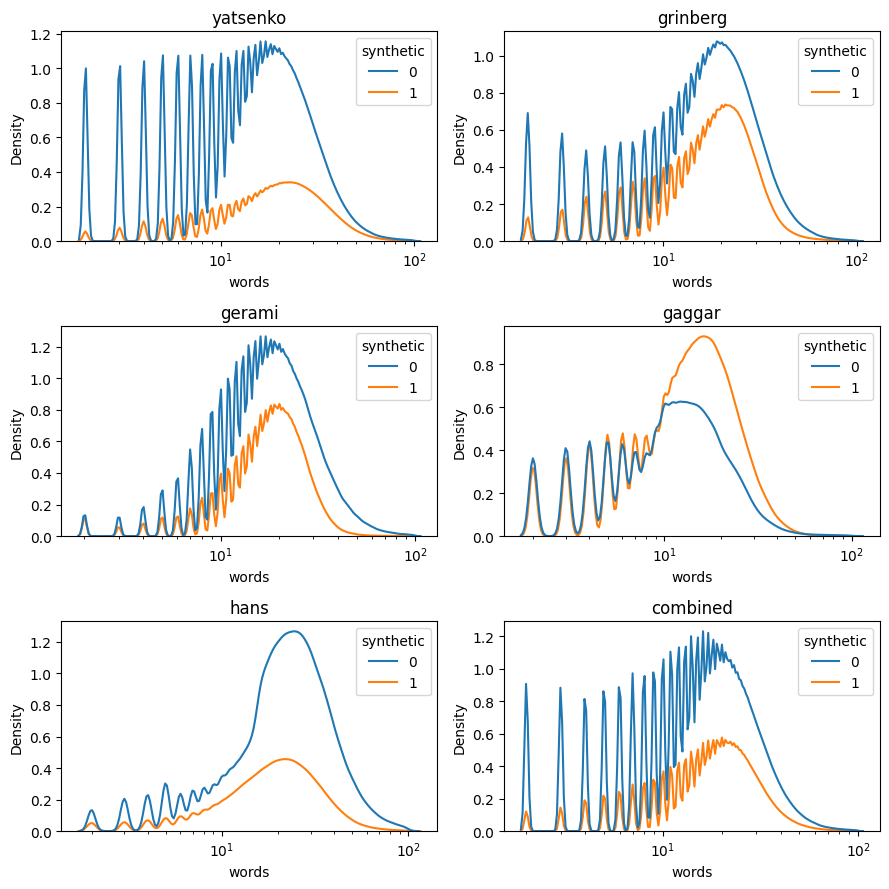

In [34]:
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(9, 9), squeeze=True)
axs=axs.flatten()

for i, dataset in enumerate(datasets.index):
    plot_data_df=working_data_df[working_data_df['source'] == dataset]
    sns.kdeplot(data=plot_data_df, x='words', hue='synthetic', common_norm=True, log_scale=10, legend=True, ax=axs[i])
    axs[i].set_title(dataset)

sns.kdeplot(data=working_data_df, x='words', hue='synthetic', common_norm=True, log_scale=10, legend=True, ax=axs[-1])
axs[-1].set_title('combined')
plt.tight_layout()
plt.show()

OK - I see differences. Let's try plotting the histogram bin fractions against each other for synthetic and human text.

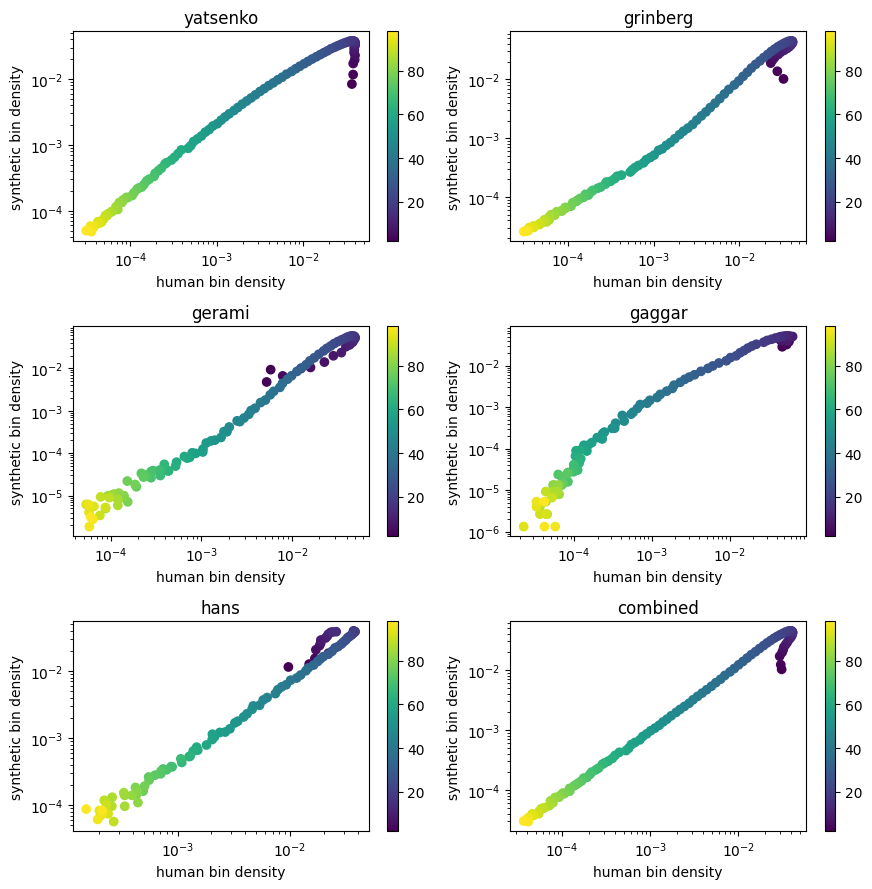

In [38]:
num_bins=100
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(9, 9), squeeze=True)
axs=axs.flatten()

# Loop on the datasets from each source
for i, dataset in enumerate(datasets.index):
    plot_data_df=working_data_df[working_data_df['source'] == dataset]

    # Get bins for human and synthetic data together
    counts, bins=np.histogram(plot_data_df['words'], bins=num_bins)

    # Use the bin edges to get densities for human and synthetic separately
    human_density, human_bins=np.histogram(plot_data_df['words'][plot_data_df['synthetic'] == 0], bins=bins, density=True)
    synthetic_density, synthetic_bins=np.histogram(plot_data_df['words'][plot_data_df['synthetic'] == 1], bins=bins, density=True)

    # Plot the bin densities against each other
    this_plot=axs[i].scatter(x=human_density, y=synthetic_density, c=bins[:-1])
    fig.colorbar(this_plot)
    axs[i].set_yscale('log')
    axs[i].set_xscale('log')
    axs[i].set_xlabel('human bin density')
    axs[i].set_ylabel('synthetic bin density')
    axs[i].set_title(dataset)

# Do the same for the complete dataset
counts, bins=np.histogram(working_data_df['words'], bins=num_bins)
human_density, human_bins=np.histogram(working_data_df['words'][working_data_df['synthetic'] == 0], bins=bins, density=True)
synthetic_density, synthetic_bins=np.histogram(working_data_df['words'][working_data_df['synthetic'] == 1], bins=bins, density=True)

last_plot=axs[-1].scatter(x=human_density, y=synthetic_density, c=bins[:-1])
axs[-1].set_yscale('log')
axs[-1].set_xscale('log')
axs[-1].set_xlabel('human bin density')
axs[-1].set_ylabel('synthetic bin density')
axs[-1].set_title('combined')
fig.colorbar(last_plot)
plt.tight_layout()
plt.show()